In [1]:
import pathlib

import yaml

import numpy as np

import itertools

In [2]:
from pixell import enmap, utils as putils

In [3]:
import utilities as u

In [4]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'cmss10'}
font = font_manager.FontProperties(family='Latin Modern Roman',
                                   style='normal', size = 8)


In [5]:
import best
import re

In [6]:
values_file = 'configurations/config.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [7]:


plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [8]:
estimators

['hu_ok', 'shear', 'bh']

In [9]:
noisetag = data['noisekey']
trispectrumtag = data['trispectrumkey']
primarytag = data['primarykey']
secondarytag = data['secondarykey']
primarycrosstag = data['primarycrosskey']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [10]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']

In [11]:
noisebiasconstr = False

In [14]:
get_dir = lambda h, s, b, p, sy, sybh: f'h{h}s{s}b{b}'

In [15]:
l = 3500

In [16]:
kk = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l, l, l)/'kk_148.npy')
theta = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l, l, l)/'theta_148.npy')
ells = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l, l, l)/'ells_148.npy')
selection = (ells > 30) & (ells < 1200)

In [17]:
resultspath = pathlib.Path(results_directory)

In [18]:
paperplots = pathlib.Path('paperplots/')

In [19]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)

In [20]:
def get_est_weights(Opt, index):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
    '''
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    zeros = np.zeros(Nest*nbins)
    for j in range(nbins):
        zeros[index+Nest*j:index+(Nest*j+1)] = 1.
    return zeros

In [21]:
fb = 1.
invvariance = False
noisebiasconstr = False

In [23]:
analysis_directory_ref = analysis_directory
analysis_directory

'output1102/'

In [92]:
reference_directory = pathlib.Path(analysis_directory_ref)/'h4000s4500b3000/total/'

kk = np.load(reference_directory/'kk_total_148.npy')
theta = np.load(reference_directory/'theta_total_148.npy')
ells = np.load(reference_directory/'ells_total_148.npy')
selection = (ells > 30) & (ells < 1200)
biases = np.load(reference_directory/'totalbias_total_148.npy')
noises = np.load(reference_directory/'N_total_148.npy')
estimators_reference = ['h', 's', 'b']#, 'p', 'sy', 'sybh']
Optimizerkk = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
#x_estimator = get_est_weights(Optimizerkk, index = 0)
#f, n, b = fnb_getter(Optimizerkk, fb, True)
#f_ref, n_ref, b_ref = f(x_estimator), n(x_estimator), b(x_estimator)

In [93]:
reference_directory

PosixPath('output1102/h4000s4500b3000/total')

In [94]:
Nells = len(ells)

In [95]:
lmax_sel = 1200

In [112]:
Optimizerkk = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
Optimizerkk_ = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises, biases_errors = biases*0.+0.01*kk)


In [97]:
from scipy.ndimage import gaussian_filter1d

In [98]:
Optimizerkk.biases_selected.shape

(3, 3, 8)

In [99]:
#loss = (fractional noise)^2 + (fractional bias)^2 + (uncertainty on the fractional bias)^2,
#where the last term could basically be (0.01)^2. This way, even if an estimator has a bias=0, it counts just like a bias bias=1%. 

In [100]:
optversion = {'weights_name': 'absbias', 'sum_biases_squared': False, 'abs_biases': True, 'bias_squared': False,
                      'color': 'purple', 'latexformula': '\sigma^2(\hat{A}_{\rm{comb}})+\left(\int_{\vec{L}}\vec{a}^TB\vec{a}\right)^2'}

In [101]:
regularised = False

In [102]:
Nrolled = np.rollaxis(Optimizerkk.noises_selected, -1)
Ne = Optimizerkk.noises_selected.shape[0]
e = np.ones(Ne)
weights = np.linalg.inv(Nrolled).dot(e)
weights /= weights.dot(e.T)[:, None]

In [103]:
combinedtheta = Optimizerkk.get_variance_part(weights, Optimizerkk.theta_selected)

In [104]:
weights_l = Optimizerkk.get_mv_weights(Optimizerkk.ells_selected, Optimizerkk.theory_selected, combinedtheta)

In [105]:
weights_l.shape

(8,)

In [113]:
regularised = False
result = Optimizerkk.optimize(optversion, x0 = None, method = 'diff-ev', gtol = 500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = 0., inv_variance = invvariance, regularise = regularised, regtype = 'biaserror',
                              scale = 0.8, cross = 0.9, npopfactor = 1, ftol = 1e-9)

#regularised = True
#result2 = Optimizerkk.optimize(optversion, method = 'diff-ev', x0 = result.x[:-Optimizerkk.nbins], bs0 = result.x[-Optimizerkk.nbins:], gtol = 500 ,bounds = [0, 1]
#                              ,noisebiasconstr = noisebiasconstr, fb = fb, inv_variance = invvariance, regularise = regularised, regtype = 'extra')

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.000181
Generation 100 has ChiSquare: 0.000115
Generation 200 has ChiSquare: 0.000066
Generation 300 has ChiSquare: 0.000053
Generation 400 has ChiSquare: 0.000051
Generation 500 has ChiSquare: 0.000051
Generation 600 has ChiSquare: 0.000044
Generation 700 has ChiSquare: 0.000044
Generation 800 has ChiSquare: 0.000041
Generation 900 has ChiSquare: 0.000041
Generation 1000 has ChiSquare: 0.000039
Generation 1100 has ChiSquare: 0.000039
Generation 1200 has ChiSquare: 0.000039
Generation 1300 has ChiSquare: 0.000038
Generation 1400 has ChiSquare: 0.000038
Generation 1500 has ChiSquare: 0.000038
Generation 1600 has ChiSquare: 0.000038
Generation 1700 has ChiSquare: 0.000038
Generation 1800 has ChiSquare: 0.000037
Generation 1900 has ChiSquare: 0.000037
Generation 2000 has ChiSquare: 0.000037
Generation 2100 has ChiSquare: 0.000037
Generation 2200 has ChiSquare: 0.000037
Generation 2300 has ChiSquare: 0.000037
Ge

In [114]:
weights = result.x[:-Optimizerkk.nbins]
weights_l = result.x[-Optimizerkk.nbins:]

In [115]:
#weights[0]

In [116]:
#M = np.ones((3, 3))*0.+1.
#(weights[0].T@(M@weights[0]))

In [117]:
regularised = True
result_second = Optimizerkk_.optimize(optversion, x0 = weights, bs0 = weights_l, method = 'diff-ev', gtol = 1500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = 1., inv_variance = invvariance, regularise = regularised, regtype = 'biaserror',
                              scale = 0.8, cross = 0.9, npopfactor = 1, ftol = 1e-11)
regularised = False

Start optimization with diff-ev
Doing for absbias
Regularizing
Generation 0 has ChiSquare: 0.003849
Generation 100 has ChiSquare: 0.003849
Generation 200 has ChiSquare: 0.003849
Generation 300 has ChiSquare: 0.003849
Generation 400 has ChiSquare: 0.003849
Generation 500 has ChiSquare: 0.003836
Generation 600 has ChiSquare: 0.003836
Generation 700 has ChiSquare: 0.003811
Generation 800 has ChiSquare: 0.000858
Generation 900 has ChiSquare: 0.000752
Generation 1000 has ChiSquare: 0.000720
Generation 1100 has ChiSquare: 0.000532
Generation 1200 has ChiSquare: 0.000411
Generation 1300 has ChiSquare: 0.000411
Generation 1400 has ChiSquare: 0.000389
Generation 1500 has ChiSquare: 0.000357
Generation 1600 has ChiSquare: 0.000349
Generation 1700 has ChiSquare: 0.000349
Generation 1800 has ChiSquare: 0.000327
Generation 1900 has ChiSquare: 0.000323
Generation 2000 has ChiSquare: 0.000321
Generation 2100 has ChiSquare: 0.000321
Generation 2200 has ChiSquare: 0.000321
Generation 2300 has ChiSquare

In [118]:
result_third = Optimizerkk.optimize(optversion, x0 = weights, bs0 = weights_l, method = 'diff-ev', gtol = 1500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = fb, inv_variance = invvariance, regularise = regularised, regtype = 'biaserror',
                              scale = 0.8, cross = 0.9, npopfactor = 1, ftol = 1e-11, filter_biases = True)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.005752
Generation 100 has ChiSquare: 0.005752
Generation 200 has ChiSquare: 0.005752
Generation 300 has ChiSquare: 0.005752
Generation 400 has ChiSquare: 0.005750
Generation 500 has ChiSquare: 0.005605
Generation 600 has ChiSquare: 0.003424
Generation 700 has ChiSquare: 0.002088
Generation 800 has ChiSquare: 0.001043
Generation 900 has ChiSquare: 0.001043
Generation 1000 has ChiSquare: 0.001031
Generation 1100 has ChiSquare: 0.000980
Generation 1200 has ChiSquare: 0.000963
Generation 1300 has ChiSquare: 0.000951
Generation 1400 has ChiSquare: 0.000943
Generation 1500 has ChiSquare: 0.000939
Generation 1600 has ChiSquare: 0.000934
Generation 1700 has ChiSquare: 0.000928
Generation 1800 has ChiSquare: 0.000924
Generation 1900 has ChiSquare: 0.000922
Generation 2000 has ChiSquare: 0.000922
Generation 2100 has ChiSquare: 0.000919
Generation 2200 has ChiSquare: 0.000918
Generation 2300 has ChiSquare: 0.000915
Ge

In [119]:
_, _, biasf_error = Optimizerkk_.get_f_n_b(Optimizerkk_.ells_selected, Optimizerkk_.theory_selected, Optimizerkk_.theta_selected, Optimizerkk_.biases_errors_selected, 
                                   sum_biases_squared = False, bias_squared = False, fb = 1., inv_variance = False, 
                                   noiseparameter = 1.)
print(biasf_error(result_third.x))
print(biasf_error(result_second.x))

0.01
0.01


In [120]:
result_fourth = Optimizerkk.optimize(optversion, x0 = weights, bs0 = weights_l, method = 'diff-ev', gtol = 1500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = fb, inv_variance = invvariance, regularise = regularised, regtype = 'biaserror',
                              scale = 0.8, cross = 0.9, npopfactor = 1, ftol = 1e-11)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.003749
Generation 100 has ChiSquare: 0.003749
Generation 200 has ChiSquare: 0.003749
Generation 300 has ChiSquare: 0.003749
Generation 400 has ChiSquare: 0.003749
Generation 500 has ChiSquare: 0.003749
Generation 600 has ChiSquare: 0.003749
Generation 700 has ChiSquare: 0.002986
Generation 800 has ChiSquare: 0.002187
Generation 900 has ChiSquare: 0.000917
Generation 1000 has ChiSquare: 0.000661
Generation 1100 has ChiSquare: 0.000442
Generation 1200 has ChiSquare: 0.000397
Generation 1300 has ChiSquare: 0.000377
Generation 1400 has ChiSquare: 0.000345
Generation 1500 has ChiSquare: 0.000328
Generation 1600 has ChiSquare: 0.000308
Generation 1700 has ChiSquare: 0.000308
Generation 1800 has ChiSquare: 0.000308
Generation 1900 has ChiSquare: 0.000217
Generation 2000 has ChiSquare: 0.000214
Generation 2100 has ChiSquare: 0.000204
Generation 2200 has ChiSquare: 0.000185
Generation 2300 has ChiSquare: 0.000182
Ge

In [132]:
result_fifth = Optimizerkk.optimize(optversion, x0 = weights, bs0 = weights_l, method = 'diff-ev', gtol = 1500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = fb, inv_variance = invvariance, regularise = True, regtype = 'std',
                              scale = 0.8, cross = 0.9, npopfactor = 1, ftol = 1e-11)

Start optimization with diff-ev
Doing for absbias
Regularizing
Generation 0 has ChiSquare: 0.003756
Generation 100 has ChiSquare: 0.003756
Generation 200 has ChiSquare: 0.003756
Generation 300 has ChiSquare: 0.003756
Generation 400 has ChiSquare: 0.003756
Generation 500 has ChiSquare: 0.003753
Generation 600 has ChiSquare: 0.003753
Generation 700 has ChiSquare: 0.003753
Generation 800 has ChiSquare: 0.001887
Generation 900 has ChiSquare: 0.000570
Generation 1000 has ChiSquare: 0.000489
Generation 1100 has ChiSquare: 0.000471
Generation 1200 has ChiSquare: 0.000471
Generation 1300 has ChiSquare: 0.000471
Generation 1400 has ChiSquare: 0.000471
Generation 1500 has ChiSquare: 0.000471
Generation 1600 has ChiSquare: 0.000404
Generation 1700 has ChiSquare: 0.000404
Generation 1800 has ChiSquare: 0.000404
Generation 1900 has ChiSquare: 0.000381
Generation 2000 has ChiSquare: 0.000369
Generation 2100 has ChiSquare: 0.000363
Generation 2200 has ChiSquare: 0.000363
Generation 2300 has ChiSquare

In [ ]:
result_third.x

In [ ]:
result_fourth.x

In [ ]:
result.ws

In [ ]:
result_second.ws

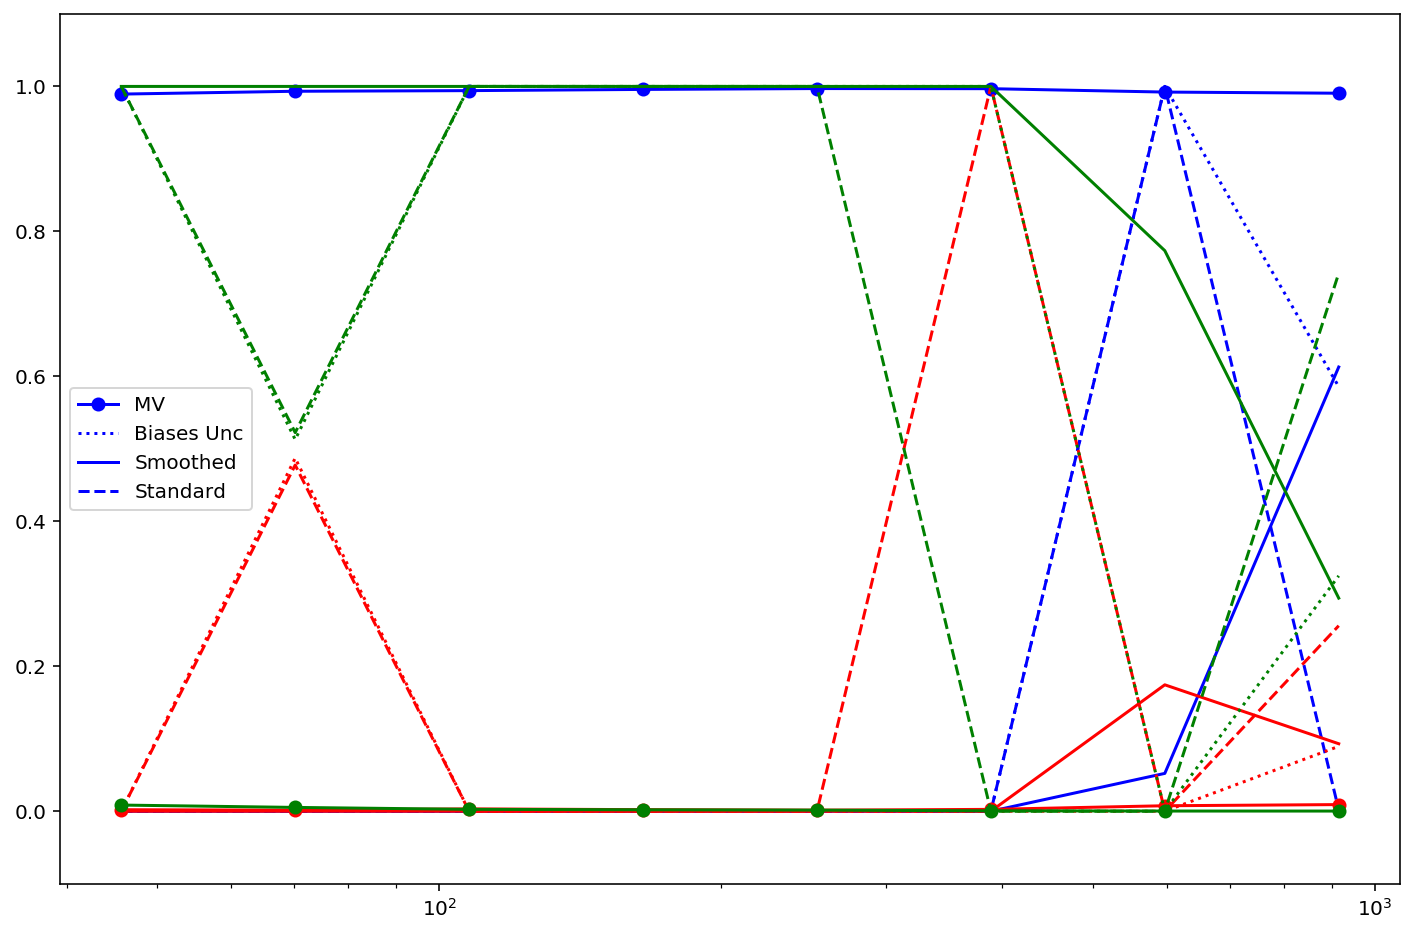

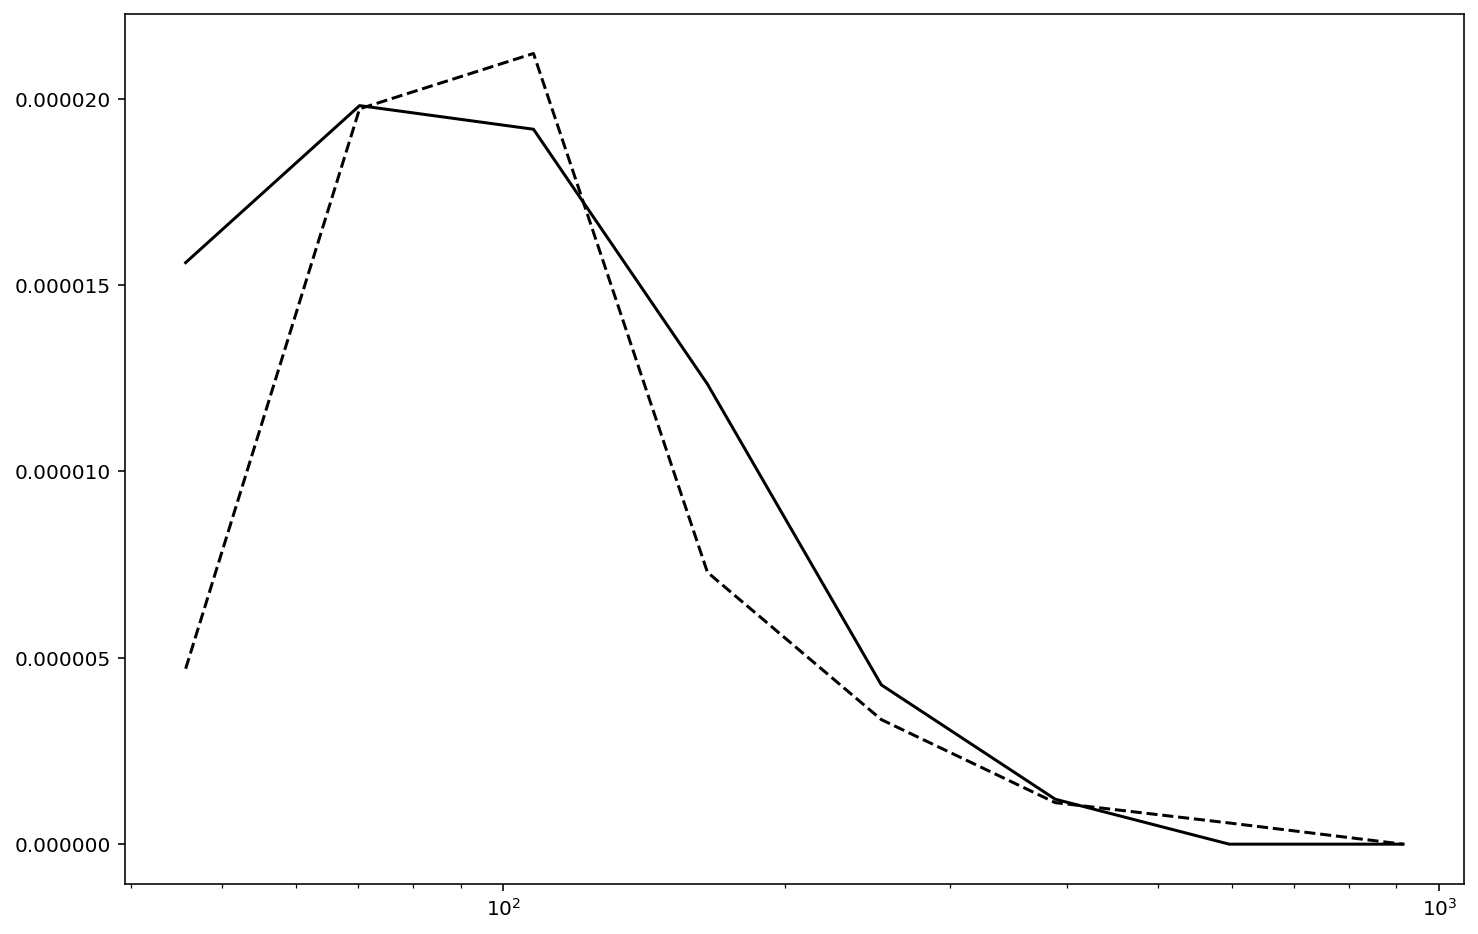

In [127]:
def plot_ris(ris, index, color, ls, marker = None, label = None):
    plt.plot(ris.ells, ris.ws[index], color = color, ls = ls, marker = marker, label = label)
    
colors = ['blue', 'red', 'green']
for index in range(3):
    if index == 0:
        label1 = 'MV'
        label2 = 'Biases Unc'
        label3 = 'Smoothed'
        label4 = 'Standard'
        label5 = '$a^2$'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None
    plot_ris(result, index, color = colors[index], ls = '', marker = 'o', label = label1)
    plot_ris(result_second, index, color = colors[index], ls = ':', label = label2)
    plot_ris(result_third, index, color = colors[index], ls = '-', label = label3)
    plot_ris(result_fourth, index, color = colors[index], ls = '--', label = label4)
    plot_ris(result_fifth, index, color = colors[index], ls = '-.', label = label5)

plt.legend()
plt.ylim(-0.1, 1.1)

plt.xscale('log')
plt.show()


plot_ris(result_third, -1, color = 'black', ls = '-')
plot_ris(result_fourth, -1, color = 'black', ls = '--')
plt.xscale('log')
plt.show()

In [129]:
f, n, b = fnb_getter(Optimizerkk, 1., False)
xx = result.x

xx0 = xx.copy()
temp = xx0[1]
xx0[1] = xx0[0]
xx0[0] = temp

print(f(xx))
print(n(xx))
print(f(xx)/f(xx0))

0.0026061266473190073
0.006103379858339
1.052799231269705


In [130]:
abs(f(result_third.x))/f(result_fourth.x)

1.7513939657928286

In [131]:
abs(f(result_third.x)-f(result_fourth.x))/f(result_fourth.x)

0.7513939657928285

In [163]:
abs(f(result.x)-f(result_second.x))/f(result_second.x)
0.0002946859641587198

0.0002946859641587198

In [164]:
xx = result_second.x
print(f(xx))
print(n(xx))

8.697004301700599e-05
0.007042348282174662


In [165]:
font = font_manager.FontProperties(family = 'cmss10',
                                   style = 'normal', size = 15)

In [166]:
def loop_over(v):
    selection = np.ones_like(v, dtype = bool)
    result = 0.
    for i, vx in enumerate(v):
        selectiontemp = selection
        selectiontemp[i] = False
        result += np.sum((1-selectiontemp*v)**2.)*vx**2.
    return result

[False False False False False False False False]
[0.13806057 0.10357409 0.11221455 0.10093054 0.07668881 0.03576064
 0.01324975 0.03759187]
[False False False False False False False False]
[0.03141155 0.00360121 0.0012406  0.01192167 0.02068504 0.00527688
 0.02568783 0.04031067]
[False False  True False False False False False]
[0.01527889 0.00640624 0.00014657 0.00882429 0.00825266 0.00923057
 0.02318563 0.03555765]
[0.29942702 0.27647    0.22956801 0.1730982  0.09526385 0.04574277
 0.01760981 0.00606583]
[0.17654365 0.148779   0.09828536 0.04926518 0.01791117 0.01296246
 0.00409912 0.00101103]
[0.2529273  0.22700392 0.17612268 0.11756036 0.05070383 0.02038799
 0.00686534 0.00204027]


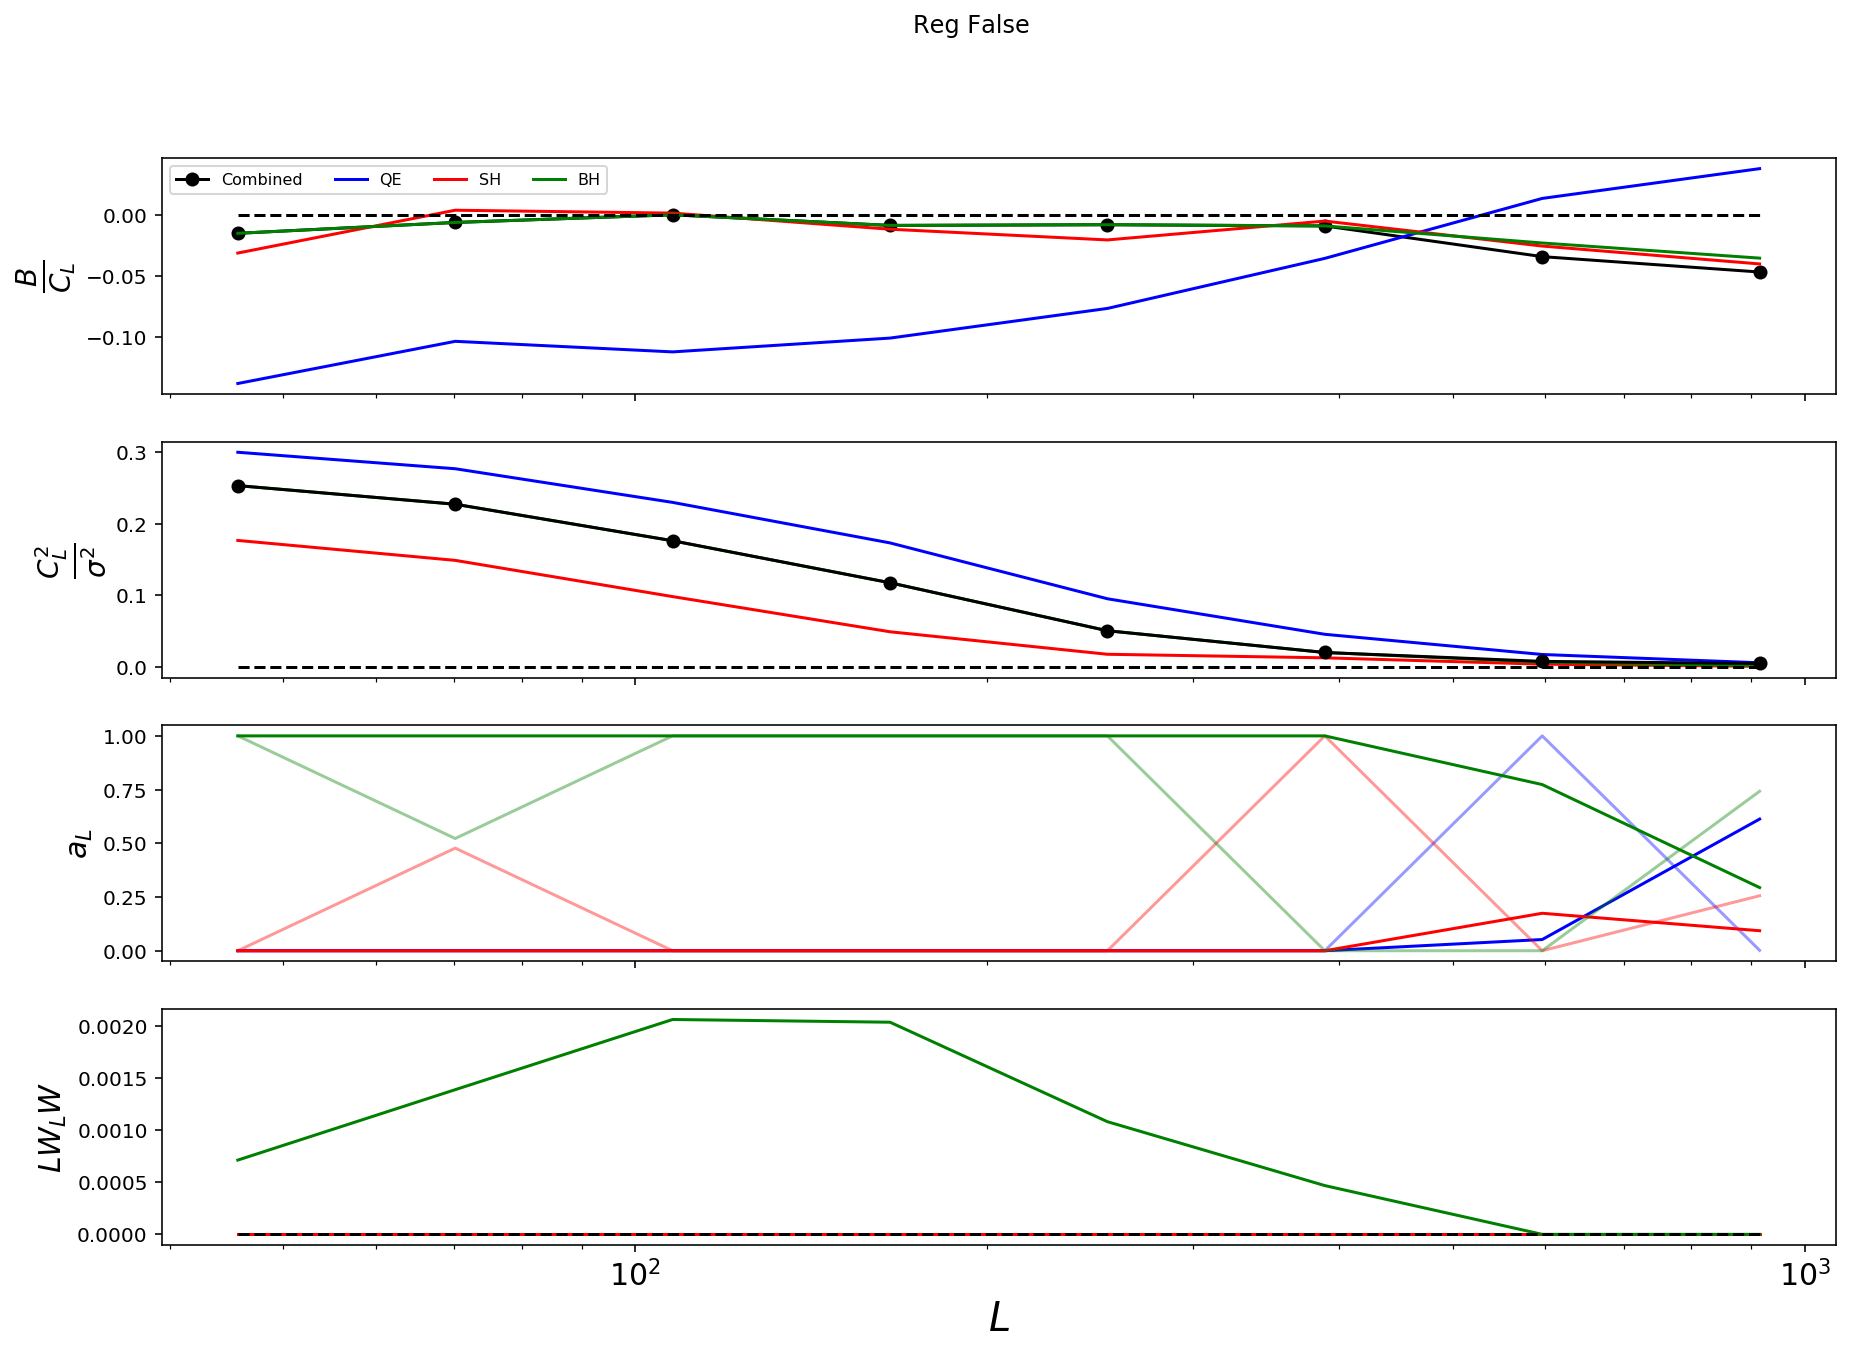

In [128]:
w = result_third.ws
w2 = result_fourth.ws

Nestimators = len(Optimizerkk.estimators)
Ne = Nestimators
a = np.c_[w[:Ne]]
a2 = np.c_[w2[:Ne]]
wl = w[-1]
combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)

combinedtheta = Optimizerkk.get_variance_part(a, Optimizerkk.theta_selected)

ells = Optimizerkk.ells_selected
kk = Optimizerkk.theory_selected
Ne = len(Optimizerkk.estimators)

names = ['QE', 'SH', 'BH']
colors = ['blue', 'red', 'green']

fig, ax = plt.subplots(nrows = 4, sharex = True, figsize = (15, 10))
fig.suptitle(f'Reg {regularised}')
ax[0].plot(ells, combinedb/kk, color = 'black', label = 'Combined', marker = 'o')

for i in range(Ne):
    print(abs(Optimizerkk.biases_selected[i, i]/kk)<0.001)
    print(abs(Optimizerkk.biases_selected[i, i]/kk))
    ax[0].plot(ells, Optimizerkk.biases_selected[i, i]/kk, color = colors[i], label = names[i])
ax[0].plot(ells, ells*0, color = 'black', ls = '--')
ax[0].legend(loc = 'best', ncol = len(names)+1, prop = font)


for i in range(Ne):
    print((Optimizerkk.theta_selected[i, i, i, i]/kk**2)**-1.)
    ax[1].plot(ells, (Optimizerkk.theta_selected[i, i, i, i]/kk**2)**-1., color = colors[i])

ax[1].plot(ells, (combinedtheta/kk**2)**-1., color = 'black', marker = 'o')
ax[1].plot(ells, ells*0, color = 'black', ls = '--')


        

for i in range(Ne):
    ax[2].plot(ells, w[i], color = colors[i])
    ax[2].plot(ells, w2[i], color = colors[i], alpha = 0.4)
    ax[-1].plot(ells, w[i]*wl*ells, color = colors[i])

#ax[-1].plot(ells, wl, color = 'black')
ax[-1].plot(ells, ells*0., color = 'black', ls = '--')

ax[0].set_ylabel('$\\frac{B}{C_L}$', size = 20)
ax[1].set_ylabel('$\\frac{C_L^2}{\sigma^2}$', size = 20)
ax[2].set_ylabel('$a_L$', size = 15)
ax[-1].set_ylabel('$LW_LW$', size = 15)

ax[0].set_xscale('log')
ax[-1].set_xlabel('$L$', size = 20)

ax[-1].tick_params(axis = 'x', which='major', labelsize = 15)

fig.savefig(paperplots/f'example_section2_4000.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [320]:
f, n, b = fnb_getter(Optimizerkk, 1., False)

In [321]:
wl = w[-1]

array([6.97496045e-15, 4.53907424e-05, 6.45700705e-15, 1.20363597e-14,
       7.52689869e-06, 2.82161126e-06, 1.46938027e-16, 2.80730116e-17,
       1.13191102e-17, 1.26616596e-17, 3.05832590e-18])

In [39]:
f(result.x)

0.00012340195765160917

In [40]:
n(result.x)

0.011097574658098436

In [41]:
b(result.x)

0.000495776521772217

In [128]:
x_est = get_est_weights(Optimizerkk, 0)
f_, n_, b_ = fnb_getter(Optimizerkk, 1., True)

In [129]:
f_(x_est)

0.004599248309826383

In [130]:
n_(x_est)

0.00665421745405974

In [131]:
b_(x_est)

0.06749051562923837

In [132]:
abs(n_(x_est)-n(result.x))/n(result.x)

0.4003901765327202

In [65]:
direc = pathlib.Path('output_ILC_1503/b4000sybh3000p4500sy3000/total/')

In [66]:
bias = np.load(direc/'totalbias_total_ilc.npy')
kk = np.load(direc/'kk_total_ilc.npy')
scatterbias = np.load(direc/'scatter_totalbias_ilc.npy')
ells = np.load(direc/'ells_total_ilc.npy')

In [69]:
selection = (ells>30) & (ells<1200)

In [72]:
deltay/y*100

array([-30.43637444, -50.16244546, -26.29938935, -24.69618827,
       -88.06265722, 100.61327062,  54.43002202,  45.12664924])

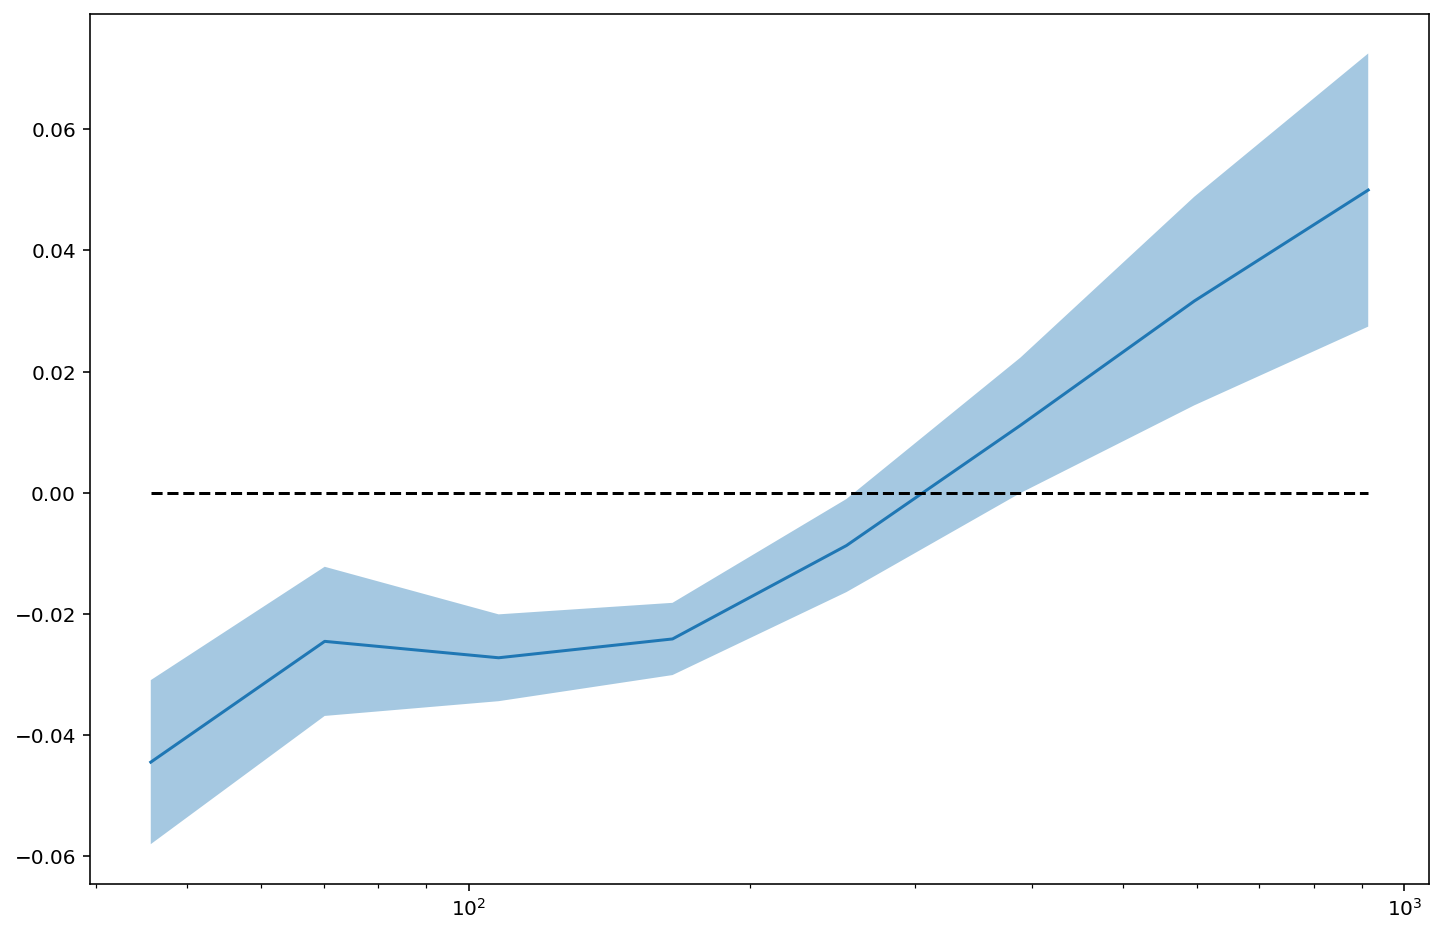

In [70]:
i = 0
y = (bias[i, i]/kk)[selection]
ellsplot = ells[selection]
deltay = (scatterbias[i, i]/kk)[selection]
plt.fill_between(ellsplot, y-deltay, y+deltay, alpha = 0.4)
plt.plot(ellsplot, y)
plt.plot(ellsplot, y*0., color = 'black', ls = '--')

plt.xscale('log')

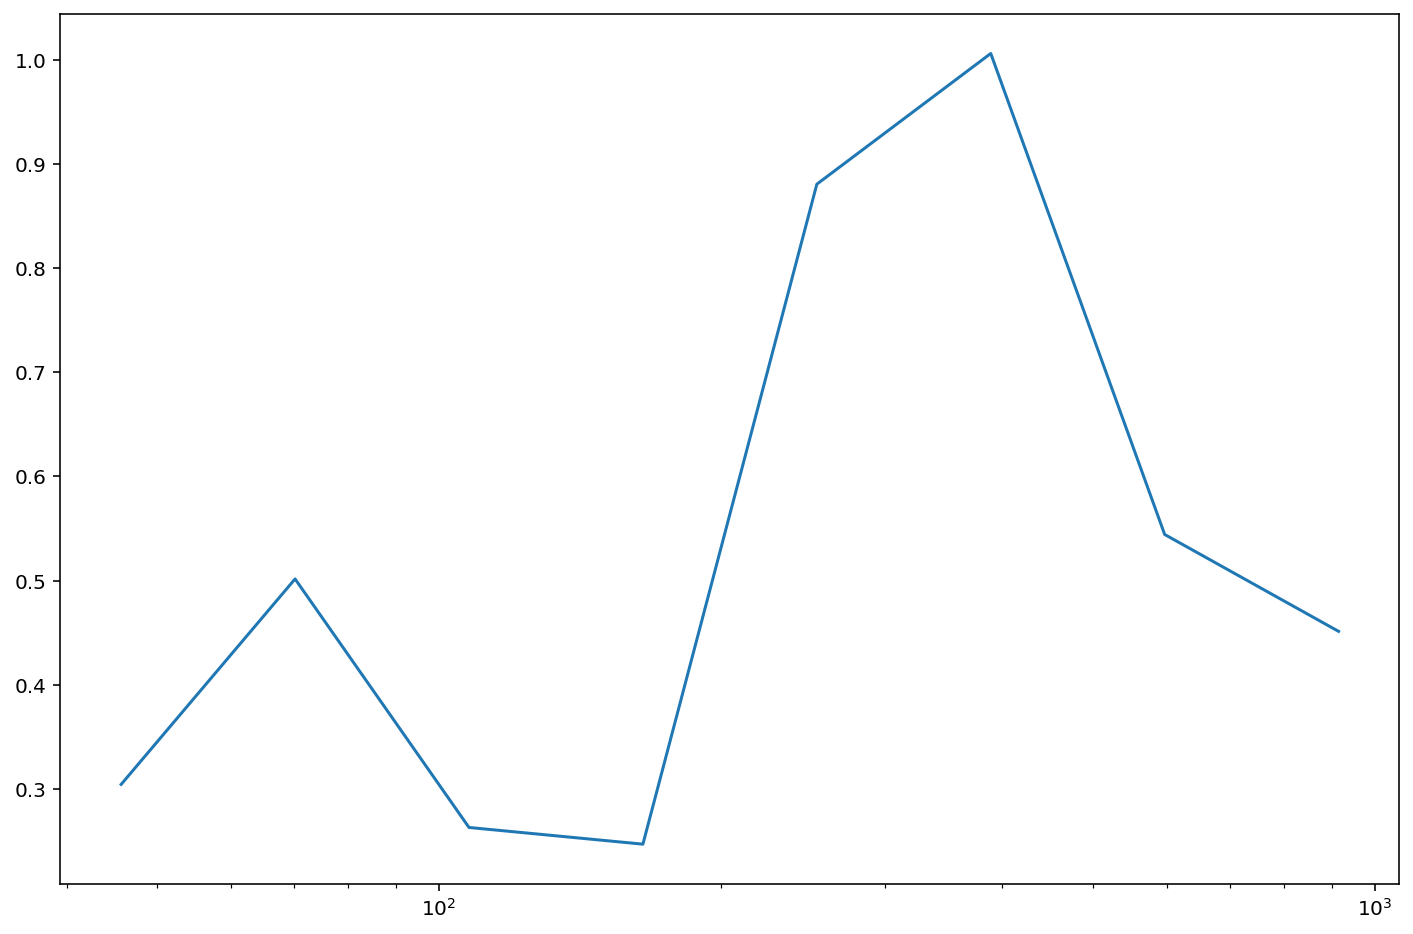

In [75]:
frac = abs(scatterbias[i, i]/bias[i, i])[selection]
plt.plot(ellsplot, frac)
plt.xscale('log')

In [51]:
from mystic.models import rosen

In [132]:
from mystic.solvers import fmin
from mystic.solvers import diffev, sparsity, buckshot, lattice

In [133]:
x0 = np.ones(5)

In [134]:
x0 = [0.8,1.2,0.7]
rosen(x0)

86.19999999999997

In [135]:
x0 = np.random.randn(20)

In [141]:
for i in range(10):
    solution = diffev(rosen,x0, maxiter = 1024**3, maxfun = 1024**3, gtol = 300, npop = 10*len(x0), scale = 0.9, mon = VerboseMonitor(100), ftol = 1e-6)
    print(solution)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4245
         Function evaluations: 849200
[1.0000069  1.00000395 0.99999599 1.00000309 0.99999203 0.99999859
 1.00000789 0.99999325 0.99999736 0.99999731 0.99998803 0.99999834
 0.99999239 1.00001058 1.00000386 0.9999969  0.99997542 0.99996772
 0.99993422 0.99985499]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4129
         Function evaluations: 826000
[1.00000668 0.99999563 0.99999401 0.99999537 1.00000434 1.00000111
 1.00000753 1.0000104  1.00001252 1.00000129 1.00000785 1.00000706
 1.00000745 0.99999979 0.9999958  0.99999646 0.99998936 0.99995844
 0.99991551 0.99985478]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4425
         Function evaluations: 885200
[0.99998941 1.000007   1.00000406 0.99999043 0.99999463 0.99999187
 1.00001101 0.99999965 1.00001287 1.00001922 0.9999

KeyboardInterrupt: 

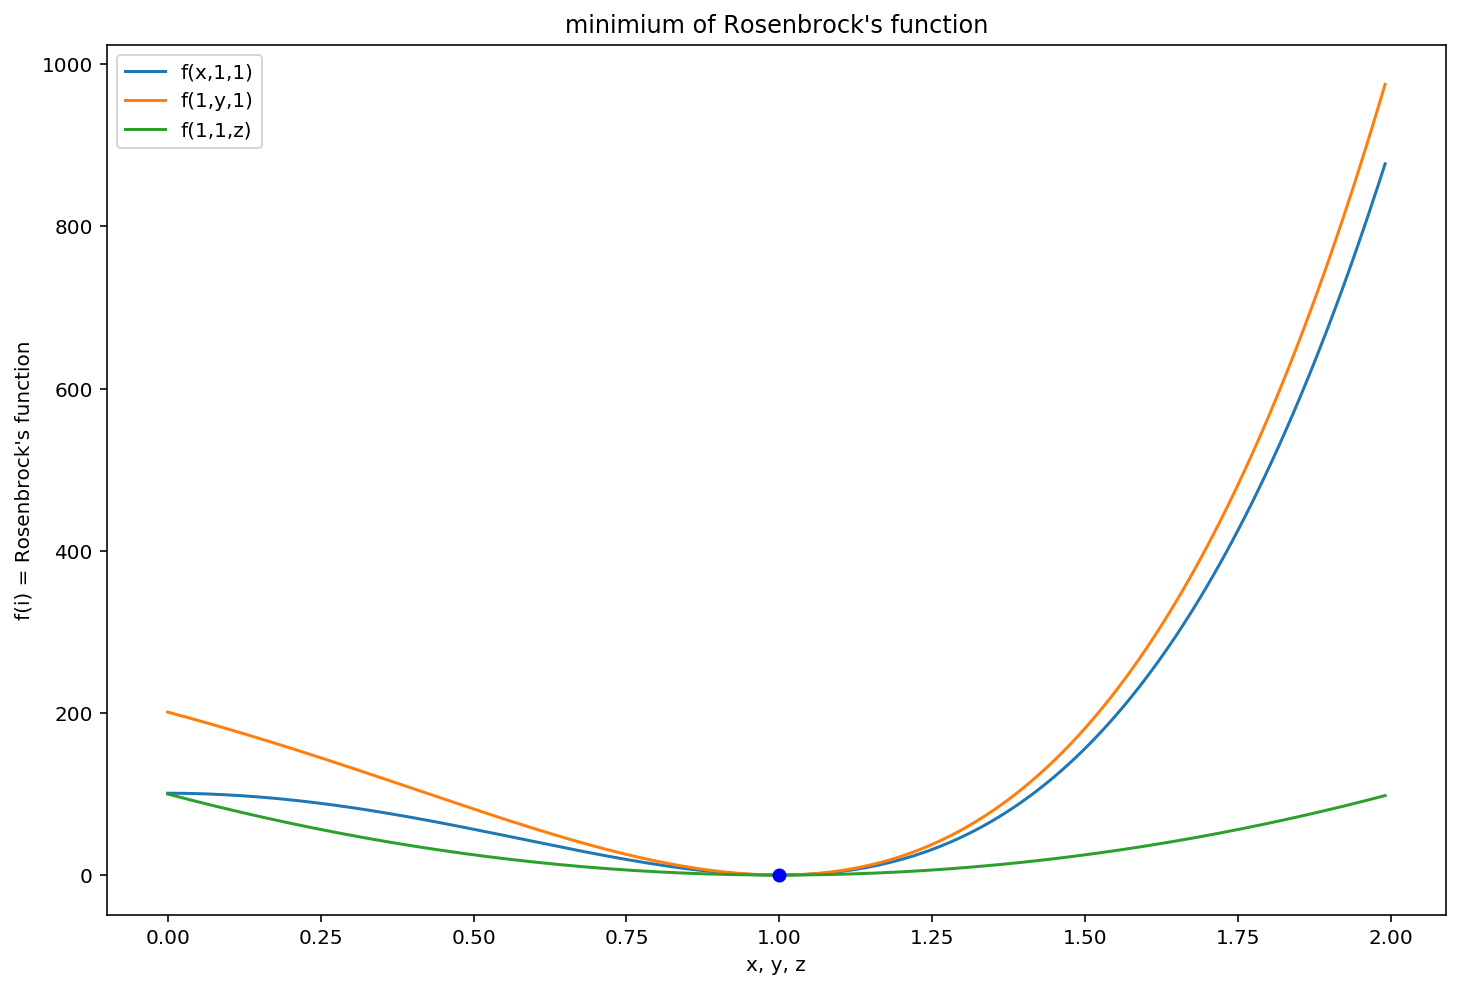

In [57]:
x = [0.01*i for i in range(200)]
plt.plot(x,[rosen([i,1.,1.]) for i in x])
plt.plot(x,[rosen([1.,i,1.]) for i in x])
plt.plot(x,[rosen([1.,1.,i]) for i in x])
# plot the solved minimum (for x)
plt.plot([solution[0]],[rosen(solution)],'bo')

# draw the plot
plt.title("minimium of Rosenbrock's function")
plt.xlabel("x, y, z")
plt.ylabel("f(i) = Rosenbrock's function")
plt.legend(["f(x,1,1)","f(1,y,1)","f(1,1,z)"])
plt.show()